In [1]:
####module to load data from all the .nc files of the various models.
import netCDF4 as nc4 
import numpy as np
import pandas as pd
import generalfunc as gf
import logging 
import readingdata 
import importlib
import matplotlib.pyplot as plt
import generalfunc as gf
import plots
import cartopy.crs as ccrs
import cartopy.feature as cpf 
import matplotlib.ticker as mticker
import matplotlib.transforms as transforms
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from scipy.interpolate import griddata
import cmocean
import datetime
import pyproj #needed for lars sea ice data

In [ ]:
fileloc="../../container/Model_n_buoy_data"
file1=fileloc+"/GTSM_final_truncated.nc"
file2=fileloc+"/gtsm_truncated_wd.nc"
[Xt,Yt,ut,vt,ssht,wdt,Tt]=readingdata.read_GTSM_map(file1,file2)
TD={'Xt': Xt,'Yt': Yt,'ut': ut,'vt': vt,'ssht': ssht,'wdt':wdt,'Tt': Tt}

C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


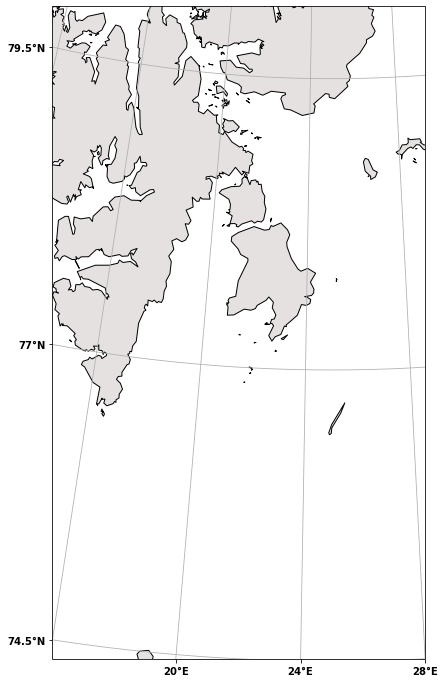

In [2]:
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
ax.set_extent([16,28,74.5,80])
fig.canvas.draw()
xticks = [ 0, 4, 12, 16, 20, 24, 28, 32, 36]
yticks = [72, 74.5, 77, 79.5, 82]
ax.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plots.lambert_xticks(ax, xticks)
plots.lambert_yticks(ax, yticks)

# gebco wms background 
# service='https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?'
# ax.add_wms(service,layers=['GEBCO_LATEST'],wms_kwargs={'width':900*2,'height':600*2})


feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
# plt.savefig(loc+'/allbuoytracks.jpg',format='jpg',dpi=600)
# plt.close(fig) 

In [ ]:
iceparmfile='../../container/Model_n_buoy_data/ice-param-mercator.nc'
icedf=xr.open_dataset(iceparmfile)
icedf.info()

In [ ]:
siconc=icedf.siconc.values
lon=icedf.longitude.values
lat=icedf.latitude.values
time=icedf.time.values
print(np.shape(siconc))

In [ ]:
# processing the velocity vector data to interpolate it to a grid,
lonmin=lon.min();lonmax=lon.max()
print(lonmin,lonmax)
latmin=lat.min();latmax=lat.max()
print(latmin,latmax)
lonvec=np.linspace(lonmin,lonmax,181);latvec=np.linspace(latmin,latmax,481)
longrid,latgrid=np.meshgrid(lonvec,latvec)

# j=5
# sicongrid=griddata((lon,lat),siconc[j,:,:],(longrid,latgrid),method='linear',fill_value=np.nan)


In [ ]:
j=30
siconct=siconc[j,:,:].T
fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
ax.set_extent([16,28,74.5,80])
fig.canvas.draw()
xticks = [ 0, 4, 12, 16, 20, 24, 28, 32, 36]
yticks = [72, 74.5, 77, 79.5, 82]
ax.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plots.lambert_xticks(ax, xticks)
plots.lambert_yticks(ax, yticks)

# gebco wms background 
# service='https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?'
# ax.add_wms(service,layers=['GEBCO_LATEST'],wms_kwargs={'width':900*2,'height':600*2})

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
ax.add_feature(cpf.OCEAN,color='black')
cmap=cmocean.cm.ice
cont=ax.contourf(longrid.T,latgrid.T,siconc[j,:,:],levels=np.linspace(0,1,50),cmap=cmap,transform=ccrs.PlateCarree())
fig.colorbar(cont)

# plt.savefig(loc+'/allbuoytracks.jpg',format='jpg',dpi=600)
# plt.close(fig) 

Use the sea ice concentration dataset from Lars. We plot the buoy locations along with sea ice concentration in nearby region. The first figure is about plotting the sea ice concentration in the region around the buoy position. We plot the average concentration in around 20kmx20km region around sea ice on a time basis.

In [4]:

# Basic scripts to read Lar's data. 

# pol=pyproj.Proj("+init=EPSG:3411")
# pol=pyproj.Proj("+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs")
pol=pyproj.Proj('EPSG:3411')
#getting the x,y index from the AMSR2 dataset for lon lat coordinates we give.
def mapxy(x,y):
    lon,lat=pol(x*1000,y*1000, inverse=True)
    return lat,lon

def mapll(lat,lon):
    x,y=pol(lon,lat, inverse=False)
    return x,y

def def_grids():
    grids={}
    grids.update({'Arc': [1,3750.0,5850.0,-3850.0,-5350.0]})
    grids.update({'Ant': [-1,3950.0,4350.0,-3950.0,-3950.0]})
    return grids

def getxyindex(lon,lat):
    hemis='Arc'
    grids=def_grids()
    cs=3.125
    sgn,cds= grids[hemis][0],grids[hemis][1:5]
    x0,y0,x2,y2=cds[0],cds[1],cds[2],cds[3]
    ###
    psxy=mapll(lat,lon)
    xi,yi=(int((psxy[0]/1000-x2)/cs),int((psxy[1]/1000-y2)/cs))
    return(xi,yi)



In [55]:
#test sicdf
loc='../../container/Model_n_buoy_data/AMSR2/'
datestr='20140415'
sicfile='Arc_'+datestr+'_res3.125_pyres.nc'
sicdf=xr.open_dataset(loc+sicfile)
lon=28.0;lat=75.0
xi,yi=getxyindex(lon,lat)

In [63]:
#function to get concentration from lars dataset in a 20km grid around the buoy location.
# def avgsicgrid(xi,yi,sicdf):
#get the grid points around xi,yi with sic
sicm=sicdf.sea_ice_concentration.values[0,xi,yi]
#the orgiginal grid is 3.125km
cs=3.125
gridsize=25.0
Npoints=int(gridsize/3.125)
datgridsize=cs*Npoints
sicmat=np.ones((1,Npoints+1))
for j in range(Npoints+1):
    sicvec=[]
    jj=(Npoints//2)-j
    for i in range(Npoints+1):
        ii=(Npoints//2)-i
        if ii==0 and jj==0:
            sici=sicm
        else:
            sici=sicdf.sea_ice_concentration.values[0,xi-ii,yi-jj]
        sicvec=np.append(sicvec,sici)
    sicmat=np.vstack((sicmat,sicvec))
sicmat=sicmat[1:,:]
sicmat=np.where(sicmat==125.0,0,sicmat)
#computing average
sumsic=0

for i in range(Npoints+1):
    if i==0 and i==Npoints:
        sumi=(sicmat[i,0]+sicmat[i,Npoints])/4+(sicmat[i,1:Npoints].sum()/2)
    else:
        sumi=(sicmat[i,0]+sicmat[i,Npoints])/2+(sicmat[i,1:Npoints].sum())
    sumsic+=sumi
sumsic=sicmat.sum()
landpoints=np.where(sicmat==0)
Nvalue=Npoints*Npoints-landpoints[0].size
# Nvalue=Npoints*Npoints
oceansize=Nvalue*cs*cs
aversic=sumsic*(cs*cs)/(oceansize)



In [68]:
def getsic(Tib,Lonib,Latib):
    sicvec=[]
    for i in range(len(Tib)-1):
        datestr=Tib[i]
        loc='../../container/Model_n_buoy_data/AMSR2/'
        try:
            date1=datetime.datetime.strptime(datestr,'%d-%m-%Y').date()
        except ValueError:
            date1=datetime.datetime.strptime(datestr,'%d-%m-%Y %H:%M').date()

        datestr=date1.strftime("%Y%m%d")
        sicfile='Arc_'+datestr+'_res3.125_pyres.nc'
        sicdf=xr.open_dataset(loc+sicfile)
        lon=Lonib[i];lat=Latib[i]
        xi,yi=getxyindex(lon,lat)
        sicm=sicdf.sea_ice_concentration.values[0,xi,yi]
        xy=((xi*3.125-3850.0),(yi*3.125-5350.0))
        lati,loni=mapxy(xy[0],xy[1])

        sicvec=np.append(sicvec,sicm)
    return(sicvec)

In [ ]:
# b='03'
barray=['02','03','09','13','14','16']
sicbdict={}
for b in barray[:]:
    Bnum=b
    bname='BUOY_'+Bnum
    loc='../../container/Model_n_buoy_data/buoy_data/'
    fname=loc+bname+'.csv'
    buoydf=pd.read_csv(fname)
    # buoydf.head()
    Lonib=np.array(buoydf['Lon'][::96]) #per day dataset
    Latib=np.array(buoydf['Lat'][::96])
    Tib=np.array(buoydf['Date(GMT)'][::96])
    sicvecb=getsic(Tib,Lonib,Latib)
    sicbdict[b]=sicvecb



97.43411569034352
93.00510390261387
76.69999851899989
84.08090660788797
86.27857072012765
92.67914743626372


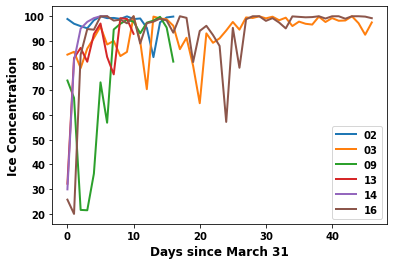

In [70]:
fig=plt.figure()
ax=plt.subplot(1,1,1)
for b in barray:
    sicb=sicbdict[b][15:]
    meansicb=sicb.mean()
    ax.plot(sicb, linestyle='-',linewidth=2,label=b)
    print(meansicb)
#     plt.plot(0,valb,marker='*',markersize=16,label=b)    
# plt.plot(barray,valb, marker='o', linestyle='None',linewidth=2, markersize=12,label='bottom') 
plt.xlabel('Days since March 31',fontsize=12,fontweight='bold')
plt.ylabel('Ice Concentration',fontsize=12,fontweight='bold')
plt.legend()

This doesn't show much so we plot the sic area around the buou location.

In [11]:

#test sicdf
loc='../../container/Model_n_buoy_data/AMSR2/'
datestr='20140415'
sicfile='Arc_'+datestr+'_res3.125_pyres.nc'
sicdf=xr.open_dataset(loc+sicfile)
xigrid=sicdf.x;yigrid=sicdf.y
# xgrid=xigrid*3.125-3850.0
# ygrid=yigrid*3.125-5350.0
sicm=sicdf.sea_ice_concentration.values[0,:,:]

# #xi yi index based on lon lat sizes. 
# lon1=0;lon2=40.0
# lat1=74.0;lat2=80.0
# x1,y1=getxyindex(lon1,lat1)
# print(x1,y1)
# x2,y2=getxyindex(lon2,lat2)
# print(x2,y2)
# x3,y3=getxyindex(lon1,lat2)
# print(x3,y3)
# x4,y4=getxyindex(lon2,lat1)
# print(x4,y4)
# #this shows that the xy grid is not square for lon lat square values. its curved. 

C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\xarray\coding\times.py:144: SerializationWarning: Ambiguous reference date string: 1-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [14]:
# processing the sic data to get it on a a grid,
lon1=0;lon2=40.0
lat1=74.0;lat2=80.0
lonvec=np.linspace(lon1,lon2,200);latvec=np.linspace(lat1,lat2,300)
longrid,latgrid=np.meshgrid(lonvec,latvec)
sicgrid=np.ones((1,len(longrid)))
for j in range(len(latvec)):
    sicgvec=[]
    for i in range(len(lonvec)):
        lonij=lonvec[j]
        latij=latvec[i]
        xij,yij=getxyindex(lonij,latij)
        sicij=sicdf.sea_ice_concentration.values[0,xij,yij]
    sicgvec=np.append(sicgvec,sicij)
sicgrid=np.vstack((sicgrid,sicgvec))
sicgrid=sicgrid[1:,:]

IndexError: index 200 is out of bounds for axis 0 with size 200

In [78]:

fig=plt.figure(figsize=(12, 12), frameon=True)
ax=plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_longitude=25.0,central_latitude=77.0)) 
ax.set_extent([16,28,74.5,80])
fig.canvas.draw()
xticks = [ 0, 4, 12, 16, 20, 24, 28, 32, 36]
yticks = [72, 74.5, 77, 79.5, 82]
ax.gridlines(xlocs=xticks, ylocs=yticks)
# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
plots.lambert_xticks(ax, xticks)
plots.lambert_yticks(ax, yticks)

# gebco wms background 
# service='https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?'
# ax.add_wms(service,layers=['GEBCO_LATEST'],wms_kwargs={'width':900*2,'height':600*2})

feature=cpf.GSHHSFeature(scale='i',levels=[1],facecolor='#e6e1e1',alpha=1)
ax.add_feature(feature) 
ax.add_feature(cpf.OCEAN,color='black')
cmap=cmocean.cm.ice
# cont=ax.contourf(xgrid*1000,ygrid*1000,sicm,levels=np.linspace(0,1,50),cmap=cmap,transform=ccrs.PlateCarree())
# fig.colorbar(cont)

# plt.savefig(loc+'/allbuoytracks.jpg',format='jpg',dpi=600)
# plt.close(fig) 

C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\shapely\geometry\multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shell = ob[0]
C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\shapely\geometry\multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  holes = ob[1]


KeyboardInterrupt: 

Reading dataset from HYCOM model. 


In [9]:
import xarray as xr
df1=xr.load_dataset('../../container/Model_n_buoy_data/hycomogcm.nc')
df1

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 376, lon: 501, time: 621)
Coordinates:
  * depth    (depth) float64 0.0
  * lat      (lat) float64 70.0 70.04 70.08 70.12 ... 84.88 84.92 84.96 85.0
  * lon      (lon) float64 0.0 0.07996 0.16 0.24 ... 39.76 39.84 39.92 40.0
  * time     (time) datetime64[ns] 2014-03-15 ... 2014-06-02T03:00:00
Data variables:
    water_u  (time, depth, lat, lon) float32 0.22 0.22 0.218 ... -0.009 -0.009
    water_v  (time, depth, lat, lon) float32 -0.069 -0.07 ... -0.031 -0.031
    surf_el  (time, lat, lon) float32 -1.061 -1.06 -1.058 ... -0.815 -0.815
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In [12]:
#hycom data.
Xo=np.array(df1.lon.values);Yo=np.array(df1.lat.values)
uo=np.array(df1.water_u.values);vo=np.array(df1.water_v.values)
ssh=np.array(df1.surf_el.values);To=np.array(df1.time.values)
df1.close()

In [13]:
print(np.sha)

(621, 376, 501)


In [ ]:
    sindex=int(sdate/4)
    eindex=sindex+int(indexing/4)
    arrlen=eindex-sindex
    OD=FD['OD']
    Xo=OD['Xo']; Yo=OD['Yo']
    uo=OD['uo']; vo=OD['vo']
    ssh=OD['ssh']; To=OD['To']
    To=gf.num2datetimesecs(1950,1,1,sindex,eindex,To*3600.)
    uo=uo[sindex:eindex,0,:,:]
    vo=vo[sindex:eindex,0,:,:]
    ssh=ssh[sindex:eindex,0,:,:]
    # processing sea surface heights to calculate pressure gradients
    logging.info("Calculating pressure gradients from sea surface heights.")
    Buoy_Xi=Xib[::4];Buoy_Yi=Yib[::4]  #buoy longitude in hourly basis (x position)    
    Uo=[];Vo=[];Uog=[];Vog=[]
    Pgx=[]; Pgy=[]
    for i in range(arrlen):
    # evaluation for sea surface heights
    # calculating the area of influence for buoy location. similar to tidal calculations,
        xk=Buoy_Xi[i];yk=Buoy_Yi[i]
        box_x1=xk-1.5;box_x2=xk+1.5
        box_y1=yk-0.5;box_y2=yk+0.5
        j1=np.array(np.where(Xo<=box_x1));j2=np.array(np.where(Xo<=box_x2))  #here i n j's are 2D arrays.
        i1=np.array(np.where(Yo<=box_y1));i2=np.array(np.where(Yo<=box_y2))
        Xon=Xo[j1[0,-1]:j2[0,-1]];Yon=Yo[i1[0,-1]:i2[0,-1]]
        sshn=ssh[i,i1[0,-1]:i2[0,-1],j1[0,-1]:j2[0,-1]]
        dzdxmat=np.zeros((len(Yon),len(Xon)))
        for j in range(len(Yon)-1):
            dzdxvec=[]
            dzdxvec=np.append(dzdxvec,0)
            for k in range(len(Xon)-1):
                # dzet=ssh[i,j,k+1]-ssh[i,j,k] #earlier wrong logic
                dzet=sshn[j,k+1]-sshn[j,k]
                lat=Yon[j];lon=Xon[k]
                dlat=0
                # dlon=Xo[k+1]-Xo[k]  ## earlier wrong logic 
                dlon=Xon[k+1]-Xon[k]
                # (dy,dx)=gf.latlon2meters(lat,lon,dlat,dlon)
                (dy,dx)=gf.latlon2meters(lat,dlat,dlon)
                dzdxvec=np.append(dzdxvec,dzet/dx)
            dzdxmat[j,:]=dzdxvec
        xinterp=interp2d(Xon,Yon,dzdxmat,kind='linear')
        Pgx=np.append(Pgx,xinterp(Buoy_Xi[i],Buoy_Yi[i]))
        dzdymat=np.zeros((len(Yon),len(Xon)))
        for j in range(len(Xon)-1):
            dzdyvec=[]
            dzdyvec=np.append(dzdyvec,0)
            for k in range(len(Yon)-1):
                # dzet=ssh[i,k+1,j]-ssh[i,k,j]
                dzet=sshn[k+1,j]-sshn[k,j]
                lat=Yon[k];lon=Xon[j]
                # dlat=Yo[k+1]-Yo[k]
                dlat=Yon[k+1]-Yon[k]
                dlon=0
                # (dy,dx)=gf.latlon2meters(lat,lon,dlat,dlon)
                (dy,dx)=gf.latlon2meters(lat,dlat,dlon)
                dzdyvec=np.append(dzdyvec,dzet/dy)
            dzdymat[:,j]=dzdyvec
        yinterp=interp2d(Xon,Yon,dzdymat,kind='linear')
        Pgy=np.append(Pgy,yinterp(Buoy_Xi[i],Buoy_Yi[i]))
        # geostrophic vel computation.
        f = 2.0*omega*np.sin(np.deg2rad(yk))
        Uogi=-g*yinterp(Buoy_Xi[i],Buoy_Yi[i])/f
        Vogi=g*xinterp(Buoy_Xi[i],Buoy_Yi[i])/f
        Uog=np.append(Uog,Uogi);Vog=np.append(Vog,Vogi)
    # for ocean currents    
        uo_time=uo[i,:,:]
        vo_time=vo[i,:,:]
        uo_ti=uo_time[i1[0,-1]:i2[0,-1],j1[0,-1]:j2[0,-1]]
        vo_ti=vo_time[i1[0,-1]:i2[0,-1],j1[0,-1]:j2[0,-1]]
        uinterp=interp2d(Xon,Yon,uo_ti,kind='linear')
        vinterp=interp2d(Xon,Yon,vo_ti,kind='linear')
        #creating winds at buoy locations
        Uo=np.append(Uo,uinterp(Buoy_Xi[i],Buoy_Yi[i]))
        Vo=np.append(Vo,vinterp(Buoy_Xi[i],Buoy_Yi[i]))

    logging.info("Done calculating and interpolating the pressure gradients to buoy locations.")
    logging.info("Interpolating ocean currents to buoy locations.")
    logging.info("Interpolation successfully done.")
    logging.info("Processing complete for ocean currents data.")

Comparing the FES and GTSM pressure gradients. The idea is that we compute the mean of the total energy loss or gain from the error in gradient computations from GTSM and FES to the mean total energy of one of the forcing in the model. So, say water-ice tidal drag. 


Peessure gradients from FES and GTSM derived waterlevels ($\zeta$).
We compute the difference as 
$$D_x^j=\nabla \zeta_{gx}^j -\nabla \zeta_{fx}^j,\forall j=0\ldots N$$
where $j$ is the time instant. The vector difference is
$$D^i=[D_x^j,D_y^j]$$

Now, we compute the energy loss or gain due to this difference. And average it over the M2 tidal cycle. Thus, we have,
$$E_D^j=\rho_i g D^j.u_{i}$$ 
where $u_i$ is the observed ice velocity vector. 
And the time-average computed as:
$$\overline{E_D}=\rho_i g \overline{D^j.u_{i}}$$

This energy difference is compared to the energy loss or gain from the water drag. The energy loss equation is:
$$E_{wi}=-\rho_wC_w|u_w-u_i|(u_w-u_i)*(u_w-u_i),$$
where $u_w=u_o+u_t# is the water velocity. 
The average computed over M2 tidal time period is given by:
$$\overline{E_{wi}}=-\rho_w C_w\overline{|u_w-u_i|^3}.$$

Then we compute how much percentage is $\overline{E_D}$ of $\overline{E_{wi}}$.


In [18]:
#iteration over the functions to plot. 
barray=['02','03','09','13','14','16'] 
# barray=['16'] 
mrelerrorvecx=[]
mrelerrorvecy=[]
gtsmenervecx=[]
gtsmenervecy=[]
fesenervecx=[]
fesenervecy=[]
errorenervec=[]
M2tim=12.42*3600
for b in barray:
    Bnum=b
    bname='BUOY_'+Bnum
    loc='../../generated_data/'+bname+'/'
    fname=loc+'Pos_Vel_data.xlsx'
    posveldf=pd.read_excel(fname)
    gtsmpgx=posveldf['Pgxt']
    gtsmpgy=posveldf['Pgyt']
    fespgx=posveldf['Fpgx']
    fespgy=posveldf['Fpgy']
    Ui=posveldf['Ut']
    Vi=posveldf['Vt']
    errorx=gtsmpgx-fespgx
    relerrorx=np.divide(errorx,gtsmpgx)
    errory=gtsmpgy-fespgy
    relerrory=np.divide(errory,gtsmpgy)
    mrelerrorvecx=np.append(mrelerrorvecx,relerrorx.mean())
    mrelerrorvecy=np.append(mrelerrorvecy,relerrory.mean())
    # #energy transfer
    # enertrajgx=928*9.818*np.multiply(gtsmpgx,Ui)
    # enertrajgy=928*9.818*np.multiply(gtsmpgy,Vi)
    # sumenergx=np.trapz(enertrajgx,dx=15*60)
    # energxmean=sumenergx/M2tim
    # gtsmenervecx=np.append(gtsmenervecx,energxmean)
    # sumenergy=np.trapz(enertrajgy,dx=15*60)
    # energymean=sumenergy/M2tim
    # gtsmenervecy=np.append(gtsmenervecy,energymean)
    # #energy transfer fes
    # enertrajfx=928*9.818*np.multiply(fespgx,Ui)
    # enertrajfy=928*9.818*np.multiply(fespgy,Vi)
    # sumenerfx=np.trapz(enertrajfx,dx=15*60)
    # enerfxmean=sumenerfx/M2tim
    # fesenervecx=np.append(fesenervecx,enerfxmean)
    # sumenerfy=np.trapz(enertrajfy,dx=15*60)
    # enerfymean=sumenerfy/M2tim
    # fesenervecy=np.append(fesenervecy,enerfymean)
    #energy transger from error.
    enertrajgerrx=928*9.81*np.multiply(errorx,Ui)
    enertrajgerry=928*9.81*np.multiply(errory,Vi)
    sumenergerr=np.trapz(enertrajgerrx+enertrajgerry,dx=15*60)
    enererrmean=sumenergerr/M2tim
    errorenervec=np.append(errorenervec,enererrmean)




In [20]:
# reading of energy data.
basefol='h1f1A1T1O1Po1Pt1Bf0'
enerval={}
for b in barray:
    bname="BUOY_"+b
    loc='../../generated_data/'+bname+'/'+basefol+'/'
    file='enerbudget_'+bname+'.xlsx'
    df=pd.read_excel(loc+file)
    mean=np.array(df['Mean_Energy(J/m^2s)'])
    std=np.array(df['Std_Energy(J/m^2s)'])
    total=np.array(df['Total_Energy(J/m^2)'])
    totmeanstd=np.row_stack((mean,std,total))
#     print(totmeanstd)
    enerval.update({b:totmeanstd})

In [21]:
print(enerval)

{'02': array([[ 2.82330936e-02, -2.59551842e-01, -6.62139064e-04,
        -3.83796885e-02],
       [ 3.91033807e-02,  4.33359087e-01,  1.87831696e-03,
         4.89536030e-02],
       [ 4.10597321e+04, -3.76672233e+05, -9.06383324e+02,
        -5.23607304e+04]]), '03': array([[ 1.24861117e-02, -8.46955324e-02, -2.78988372e-03,
        -8.21473142e-02],
       [ 3.03037315e-02,  1.95826023e-01,  1.28339608e-02,
         1.57590279e-01],
       [ 4.96156616e+04, -3.36589657e+05, -1.08433484e+04,
        -3.19349049e+05]]), '09': array([[ 1.80129017e-02, -6.14152967e-02, -2.28302428e-04,
        -2.92921112e-02],
       [ 2.90561713e-02,  1.02888499e-01,  5.46943450e-04,
         4.31396334e-02],
       [ 2.62607908e+04, -8.95134982e+04, -3.13585241e+02,
        -4.01844107e+04]]), '13': array([[ 2.33611176e-02, -8.18880885e-02, -1.85655030e-04,
        -5.67726526e-03],
       [ 3.52988930e-02,  1.57524798e-01,  5.08466242e-04,
         5.62332437e-03],
       [ 2.07605801e+04, -7.272235

In [23]:
#
meanwaterenerstd=[]
for b in barray:
    enerb=enerval[b]
    totalenerb=enerb[2,1] #enerb[mean-std-total,typ(wind,water) etc]
    meantotalenerb=totalenerb/M2tim
    meanwaterenerstd=np.append(meanwaterenerstd,meantotalenerb)

In [26]:
print(meanwaterenerstd)
print(errorenervec)
print((errorenervec/meanwaterenerstd)*100)

[-8.4244103  -7.52794902 -2.00200166 -1.62646168 -1.01737619  7.85295587]
[ 0.0036218  -0.03977178 -0.01885389 -0.00683947 -0.02570208  0.03119061]
[-0.0429917   0.52832164  0.94175217  0.42051251  2.52631077  0.39718299]


Now we have to compare CMEMS to HYCOM. We compute the water level gradient differences in the same way as done for FES and GTSM. But for 
currents we compute the difference in forces from using the CMEMS derived currents and HYCOM derived currents. 
We compute the difference in forces as: 
$$D_{wi}=E_c-E_h,$$
where $E_c$ is the energy loss assuming CMEMS currents and $E_h$ is the energy loss assuming hycom currents. And we obtain,
$\%$ chane as $D_{wi}/E_c$. 

Here, the energy loss is same as before, ie:
$$E_{wi}=-\rho_wC_w|u_w-u_i|(u_w-u_i)*(u_w-u_i),$$
$u_w=u_c+u_t$ for CMEMS currents and $u_w=u_h+u_t$. 


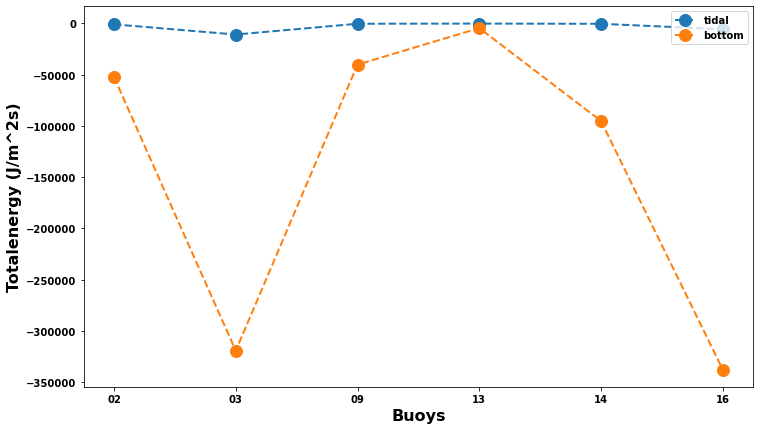

In [22]:
#plotting.
# i=4 is the total number of lines or variables to be plotted
#mean plot.
valtyp=['wind','water','tidal','bottom']
fig=plt.figure(figsize=(12,7),frameon=True)
for i in range(4):
    if i>1:
        val=[]
        for b in barray:
            meanstd=enerval[b]
            val=np.append(val,meanstd[2,i])
        plt.plot(barray,val, marker='o', linestyle='dashed',linewidth=2, markersize=12,label=valtyp[i]) 
plt.xlabel('Buoys',fontsize=16,fontweight='bold')
plt.ylabel('Totalenergy (J/m^2s)',fontsize=16,fontweight='bold')
plt.legend(loc=1) 

[-10.20289967   0.65183868  -1.7282296    0.05933304   0.8253328
  -0.30268286]
[-1.02422889  0.33900186  0.39993677  0.13647349  0.17082717  0.27506806]


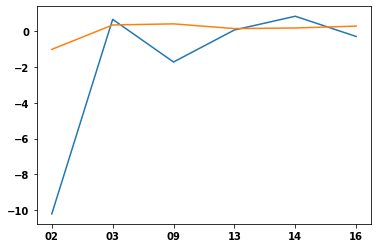

In [47]:
plt.plot(barray,mrelerrorvecx)
print(mrelerrorvecx)
plt.plot(barray,mrelerrorvecy)
print(mrelerrorvecy)

PRessure gradients from FES and GTSM derived waterlevels. $\zeta$.
We compute the error as 
$$E_x^i=\nabla \zeta_{gx}^i -\nabla \zeta_{fx}^i,\forall i=0\ldots N$$
where $i$ is the time instant.
A relative error is computed as:
$$\hat{E}_x^i=\frac{E_x^i}{\nabla \zeta_{gx}^i}$$
And the mean of this over the entire time cycle as:
$$\overline{\hat{E}_x}=(\sum_{i=0}^N \hat{E}_x^i//N

In [6]:

sumerelerror=np.trapz(errorx,dx=15*60)
M2tim=12.42*3600
relerrormean=sumerelerror/M2tim
print(relerrormean)

-4.878127127667776e-06


In [39]:
# import scipy.stats as stats
# U1,p=stats.mannwhitneyu(gtsmpgx,fespgx)
# print(U1)

Plotting of sea ice concentrations from AMSR2 datset obtained from Lars.

In [32]:
#amsr2 .nc file read.
loc='../../container/Model_n_buoy_data/AMSR2/'
date1=datetime.date(2014,3,15)
datestr=date1.strftime("%Y%m%d")
sicfile='Arc_'+datestr+'_res3.125_pyres.nc'
sicdf=xr.open_dataset(loc+sicfile)
sicdf

C:\Users\vasulkar\Anaconda3\envs\buoymodel\lib\site-packages\xarray\coding\times.py:144: SerializationWarning: Ambiguous reference date string: 1-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


<xarray.Dataset>
Dimensions:                (x: 2432, y: 3584, time: 1)
Coordinates:
  * x                      (x) float64 1.0 2.0 3.0 ... 2.431e+03 2.432e+03
  * y                      (y) float64 1.0 2.0 3.0 ... 3.583e+03 3.584e+03
  * time                   (time) datetime64[ns] 2014-03-15T12:00:00
Data variables:
    sea_ice_concentration  (time, y, x) float32 ...
    land                   (time, y, x) int8 ...
Attributes: (12/23)
    CDI:                Climate Data Interface version 1.6.2 (http://code.zma...
    Conventions:        CF-1.4
    history:            Sun Mar 16 20:41:58 2014: cdo setdate,2014-03-15 -set...
    grid_resolution:    3.125 km
    description:        gridded ASI AMSR2 sea ice concentration
    algorithm:          ASI v5
    ...                 ...
    grid:               NSIDC polar stereographic with tangential plane at 70...
    missing_value:      11500
    sensor:             AMSR2
    cite:               Spreen, G., L. Kaleschke, G. Heygster, Sea Ice Remote...
    geocorrection:      none
    CDO:                Climate Data Operators version 1.6.2 (http://code.zma...